In [33]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib inline


In [34]:
import numpy as np
import pandas as pd

In [35]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [37]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [39]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# get the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# examine the columns in the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# examine the columns in the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Quick check to find the min and max dates
print(session.query(Measurement.date, Measurement.prcp).limit(5).all())
print(session.query(Measurement.date, Measurement.prcp, func.min(Measurement.date)).all())
print(session.query(Measurement.date, Measurement.prcp, func.max(Measurement.date)).all())
# query.(Model).filter(something).limit(5).all()
#session.query(self.stats.c.ID, func.max(self.stats.c.STA_DATE))

[('2010-01-01', 0.08), ('2010-01-02', 0.0), ('2010-01-03', 0.0), ('2010-01-04', 0.0), ('2010-01-06', None)]
[('2010-01-01', 0.08, '2010-01-01')]
[('2017-08-23', 0.0, '2017-08-23')]


In [14]:
# quick test to see the query reuslts
print(session.query(Measurement.prcp).distinct().all())

[(0.08,), (0.0,), (None,), (0.06,), (0.01,), (0.04,), (0.12,), (0.03,), (0.02,), (0.43,), (0.17,), (0.15,), (0.27,), (0.2,), (0.05,), (0.09,), (0.07,), (0.57,), (0.31,), (0.23,), (1.58,), (0.77,), (1.4,), (0.13,), (0.55,), (0.22,), (1.29,), (1.3,), (0.29,), (1.72,), (0.82,), (0.1,), (0.88,), (0.4,), (1.11,), (0.36,), (2.1,), (0.11,), (0.56,), (0.89,), (0.14,), (1.6,), (0.58,), (0.28,), (0.7,), (0.18,), (1.03,), (0.37,), (1.08,), (4.0,), (2.42,), (0.19,), (1.0,), (1.13,), (0.8,), (0.32,), (0.3,), (0.25,), (0.35,), (0.74,), (1.98,), (2.01,), (1.1,), (0.16,), (0.76,), (0.38,), (0.5,), (0.48,), (0.64,), (0.45,), (0.66,), (1.09,), (0.79,), (0.39,), (0.24,), (1.22,), (0.62,), (0.93,), (0.86,), (0.46,), (0.65,), (0.26,), (0.41,), (0.42,), (0.52,), (1.57,), (0.85,), (0.33,), (0.75,), (0.21,), (0.54,), (1.25,), (4.2,), (1.32,), (0.51,), (2.62,), (1.19,), (0.73,), (0.47,), (1.7,), (0.87,), (0.34,), (0.44,), (0.49,), (1.95,), (3.18,), (4.94,), (2.95,), (0.99,), (0.63,), (5.21,), (1.06,), (1.54,),

In [15]:
print(session.query(Station).limit(5).all())

[<sqlalchemy.ext.automap.station object at 0x0000027BF2CDB748>, <sqlalchemy.ext.automap.station object at 0x0000027BF2CDB7B8>, <sqlalchemy.ext.automap.station object at 0x0000027BF2CDB828>, <sqlalchemy.ext.automap.station object at 0x0000027BF2CDB898>, <sqlalchemy.ext.automap.station object at 0x0000027BF2CDB908>]


In [66]:
# /api/v1.0/stations
# Return a JSON list of stations from the dataset.
# identify the station names and count how many stations there are 
query_result = session.query(Station.station).all()
print(query_result)
print(len(query_result))

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]
9


In [71]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Select only the `date` and `prcp` values.

# Calculate the date 1 year ago from the last data point in the database 
## this was already determined earlier when examining the data for min and max dates 

# Perform a query to retrieve the data and precipitation scores
prcp_calc = [Measurement.date, 
       func.sum(Measurement.prcp)]

# we know from previous query that the latest date is 2017-08-23
# alternatively we could've just used 2016-08-23
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

prcp_by_day = session.query(*prcp_calc).\
    filter(Measurement.date >= year_ago).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [72]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_by_day = pd.DataFrame(prcp_by_day, columns=['Date', 'Precipitation'])
print(max(df_by_day['Date']))
print(max(df_by_day['Precipitation']))

df_by_day.set_index('Date', inplace=True)
df_by_day.sort_values(by='Date', ascending=False)
df_by_day.head(10)

2017-08-23
14.280000000000001


,Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
2016-08-29,1.46
2016-08-30,0.07
2016-08-31,3.18


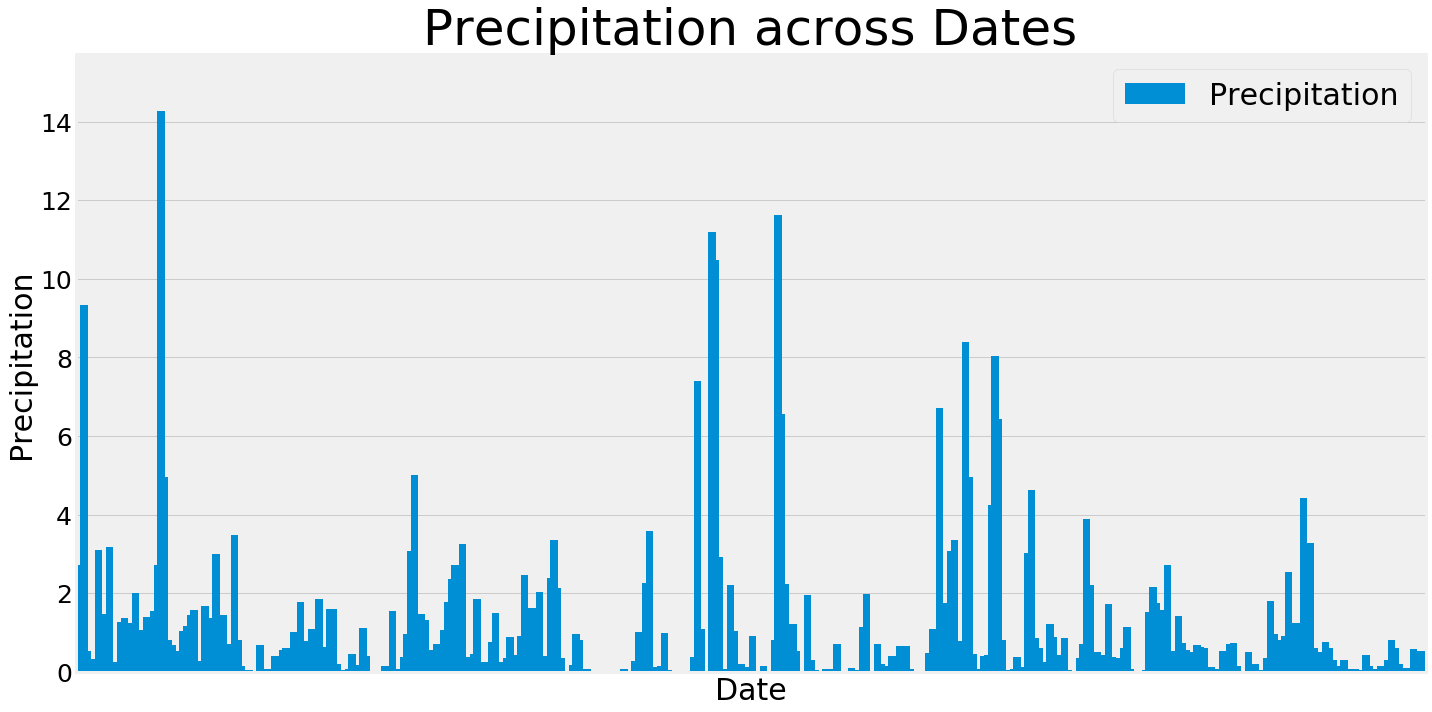

In [132]:
# Plot the Results in a Matplotlib bar chart
## https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

df_by_day.plot.bar(width=2, figsize=(20,10))
plt.xticks([])
#plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=25, rotation=0)
plt.ylim(0,max(df_by_day['Precipitation']*1.1))
plt.ylabel('Precipitation', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.title('Precipitation across Dates', fontsize=50)
plt.legend(loc=1, prop={'size': 30})
plt.tight_layout()
plt.savefig("Precipitation Analysis By Date")
plt.show()

2017-08-23
6.7


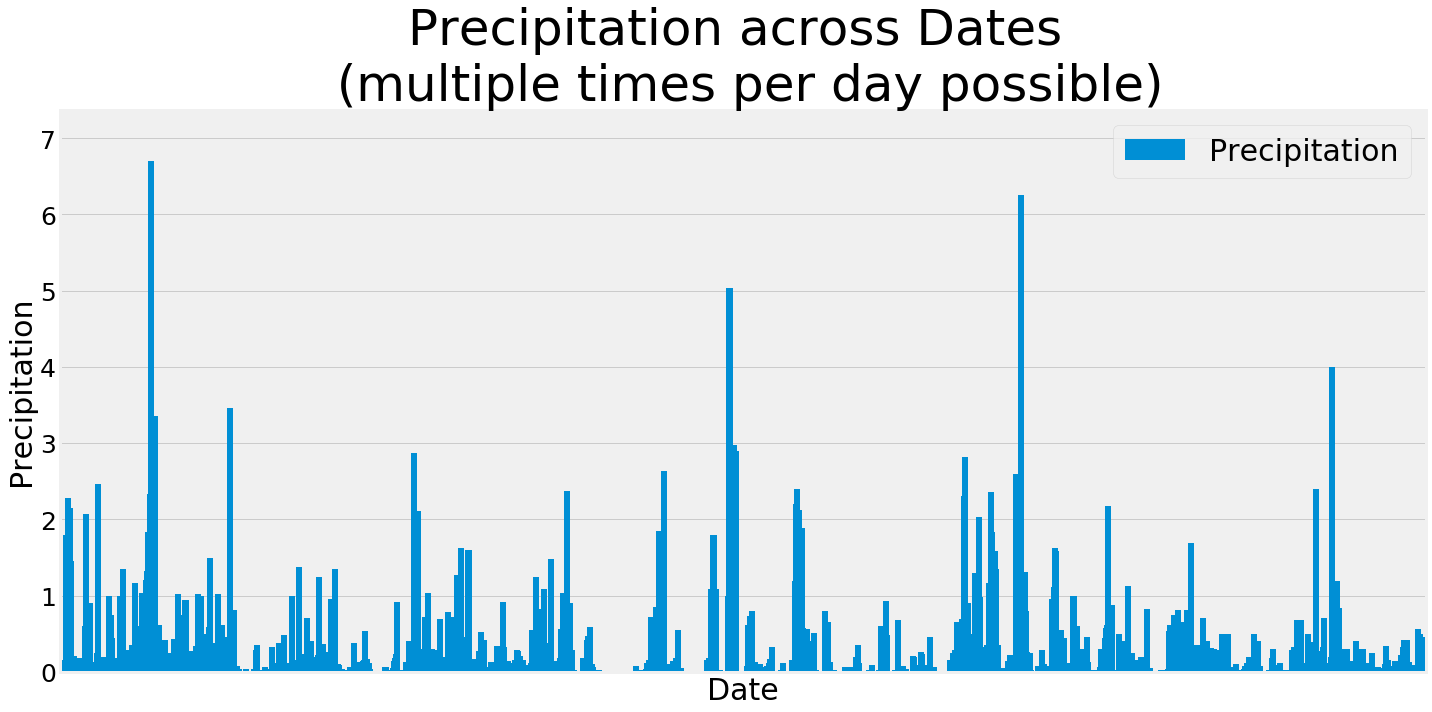

In [133]:
prcp_multiple_times_per_day = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

df = pd.DataFrame(prcp_multiple_times_per_day, columns=['Date', 'Precipitation'])
print(max(df['Date']))
print(max(df['Precipitation']))

df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=False)
df.head(10)

df.plot.bar(width=10, figsize=(20,10))
plt.xticks([])
#plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=25, rotation=0)
plt.ylim(0,max(df['Precipitation']*1.1))
plt.ylabel('Precipitation', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.title('Precipitation across Dates \n (multiple times per day possible)', fontsize=50)
plt.legend(loc=1, prop={'size': 30})
plt.tight_layout()
plt.savefig("Precipitation Analysis (multiple times per day possible)")
plt.show()

In [1]:
## BELOW IS FROM GUIDE

![precipitation](Images/precipitation.png)

In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# based on "per day" data
df_by_day.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [77]:
# Use Pandas to calcualte the summary statistics for the precipitation data
## using every date, with multiple entries per day
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
## BELOW IS FROM GUIDE

![describe](Images/describe.png)

In [78]:
# Design a query to show how many stations are available in this dataset?
print(session.query(func.count(Station.station)).all())

station_ids = session.query(Station.id, Station.station).\
    order_by(Station.id).all()
df_station = pd.DataFrame(station_ids, columns=['ID', 'Station'])
df_station.set_index('ID', inplace=True)
print(df_station)


[(9,)]
        Station
ID             
1   USC00519397
2   USC00513117
3   USC00514830
4   USC00517948
5   USC00518838
6   USC00519523
7   USC00519281
8   USC00511918
9   USC00516128


In [12]:
## BELOW IS FROM GUIDE

[(9)]

In [79]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations_id2 = session.query(func.count(Measurement.station), Measurement.station).\
       group_by(Measurement.station).\
       order_by(func.count(Measurement.station).desc()).all()

print(stations_id2)
print('')

df_station2 = pd.DataFrame(stations_id2, columns=['Count', 'Station'])
df_station2.set_index('Count', inplace=True)
print(df_station2)

[(2772, 'USC00519281'), (2724, 'USC00519397'), (2709, 'USC00513117'), (2669, 'USC00519523'), (2612, 'USC00516128'), (2202, 'USC00514830'), (1979, 'USC00511918'), (1372, 'USC00517948'), (511, 'USC00518838')]

           Station
Count             
2772   USC00519281
2724   USC00519397
2709   USC00513117
2669   USC00519523
2612   USC00516128
2202   USC00514830
1979   USC00511918
1372   USC00517948
511    USC00518838


In [13]:
## BELOW IS FROM GUIDE

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [80]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp_calc = [Measurement.station, 
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]


session.query(*temp_calc).\
    filter(Measurement.station == 'USC00519281').all()#.\
    #group_by(Measurement.station).all()#\
    #order_by(Measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [14]:
## BELOW IS FROM GUIDE

[(54.0, 85.0, 71.66378066378067)]

In [81]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

## we know from previous query that station USC00519281 has the most number of observations
## tobs = Temperatue at observation time 
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
histo_data = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date >= year_ago).\
    filter(Measurement.station == 'USC00519281').all()

df = pd.DataFrame(histo_data, columns=['Date', 'Station', 'Temp'])
print(max(df['Date']))
print(max(df['Temp']))

df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=False)

df.head(5)

2017-08-18
83.0


,Station,Temp
Date,,
2016-08-23,USC00519281,77.0
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0


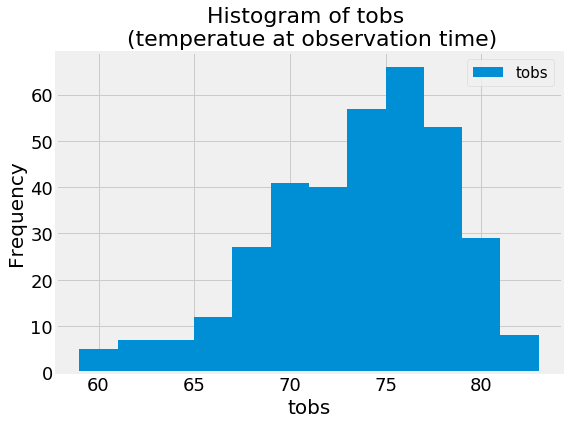

In [131]:
### FIX THE TITLE AND AXES
plt.figure(figsize=(8,6))
plt.hist(df['Temp'], bins=12) #, bins=range(min(df), max(df) + binwidth, binwidth))
plt.legend(['tobs'], prop={'size': 15})
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('tobs', fontsize=20)
plt.title('Histogram of tobs \n (temperatue at observation time)', fontsize=22)
#plt.legend(loc=1, )
plt.tight_layout()
plt.savefig("Histogram of tobs")

In [292]:
# BELOW IS FROM GUIDE

![precipitation](Images/station-histogram.png)

In [84]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [96]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


## in this example I assume the 'trip' start date of 2018-01-01 and end date of 2018-01-08, 
## so for the look back into the previous year I'll use the 'start' date of 2017-01-01 and 'end' date of 2017-01-08
print(calc_temps('2017-01-01', '2017-01-08'))
df_bar = calc_temps('2017-01-01', '2017-01-08')


[(60.0, 68.27659574468085, 74.0)]


In [17]:
## BELOW IS FROM GUIDE

62.0 68.36585365853658 74.0


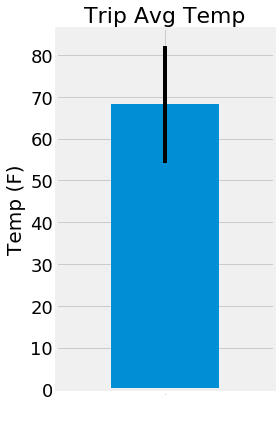

In [102]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

start = '2017-01-01'
end = '2017-01-08'

query_result = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).\
    order_by(Measurement.date).all()

data_for_barplot = pd.DataFrame(query_result, columns=['TMIN', 'TAVE', 'TMAX'])
df_bar_yerr = data_for_barplot['TMAX']-data_for_barplot['TMIN']

plt.figure(figsize=(4,6))
df_bar = pd.DataFrame(data_for_barplot, columns=['TMIN', 'TAVE', 'TMAX'])
df_bar['TAVE'].plot(kind='bar', yerr=[[df_bar_yerr,df_bar_yerr]])
plt.xticks(fontsize=0, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.ylabel('Temp (F)', fontsize=20)
plt.xlabel(' ', fontsize=20)
plt.title('Trip Avg Temp', fontsize=22)
plt.tight_layout()
plt.savefig("Trip Avg Temp")

<IPython.core.display.Javascript object>


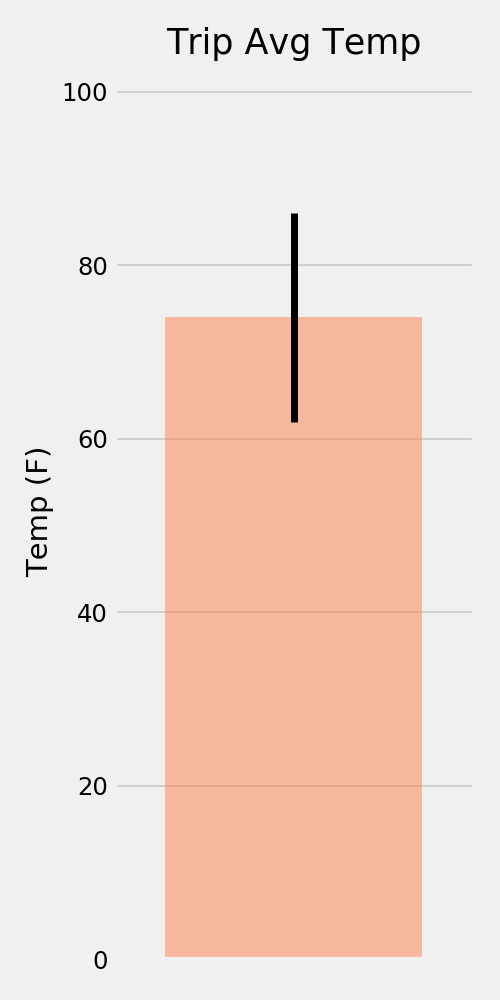

In [18]:
## BELOW FROM GUIDE

In [103]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Perform a query to retrieve the data and precipitation scores

## in this example I assume the 'trip' start date of 2018-01-01 and end date of 2018-01-08, 
## so for the look back into the previous year I'll use the 'start' date of 2017-01-01 and 'end' date of 2017-01-08
start_date = "2017-01-01"
end_date = "2017-01-08"

total_rain_per_station = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        join(Measurement, Measurement.station == Station.station) .\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
print(total_rain_per_station)

df_total_rain_per_station = pd.DataFrame(total_rain_per_station, columns=['Station_of_Measurement', 'Total_Prcp', 'Station_Name', 'Latitude', 'Longitude', 'Elevation'])
df_total_rain_per_station
# https://stackoverflow.com/questions/50617343/how-to-join-data-from-two-tables-in-sqlalchemy
# join(Account, Account.organization == User.organization).\
#     filter(Account.name == 'some name')


[('USC00516128', 0.63, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00514830', 0.63, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519523', 0.61, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00513117', 0.35, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519281', 0.2, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]


,Station_of_Measurement,Total_Prcp,Station_Name,Latitude,Longitude,Elevation
0,USC00516128,0.63,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.63,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519523,0.61,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00513117,0.35,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519281,0.20,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,USC00519397,0.00,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [19]:
## BELOW IS FROM GUIDE

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [104]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    # sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [112]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


## in this example I assume the 'trip' start date of 2018-01-01 and end date of 2018-01-08, 
## so for the look back into the previous year I'll use the 'start' date of 2017-01-01 and 'end' date of 2017-01-08

## https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
from datetime import date, timedelta
# Set the start and end date of the trip
start_date = date(2017, 1, 1)
end_date = date(2017, 1, 8)

In [113]:
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [114]:
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [115]:
start_date = date(2017, 1, 1)
end_date = date(2017, 1, 8)

daily_normals = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date.desc()).all()
print(daily_normals)

[('2017-01-08', 60.0, 67.66666666666667, 74.0), ('2017-01-07', 66.0, 70.16666666666667, 72.0), ('2017-01-06', 62.0, 67.66666666666667, 74.0), ('2017-01-05', 63.0, 67.5, 72.0), ('2017-01-04', 62.0, 67.16666666666667, 73.0), ('2017-01-03', 63.0, 67.66666666666667, 73.0), ('2017-01-02', 66.0, 69.2, 74.0), ('2017-01-01', 62.0, 69.33333333333333, 74.0)]


In [21]:
## BELOW IS EXAMPLE FROM GUIDE

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [122]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_daily_normals = pd.DataFrame(daily_normals, columns=['date', 'tmin', 'tavg', 'tmax']).sort_values(by='date', ascending=True).set_index('date')
df_daily_normals

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.333333,74.0
2017-01-02,66.0,69.200000,74.0
2017-01-03,63.0,67.666667,73.0
2017-01-04,62.0,67.166667,73.0
2017-01-05,63.0,67.500000,72.0
2017-01-06,62.0,67.666667,74.0
2017-01-07,66.0,70.166667,72.0
2017-01-08,60.0,67.666667,74.0


In [22]:
## BELOW IS EXAMPLE OF OUTPUT FROM GUIDE

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


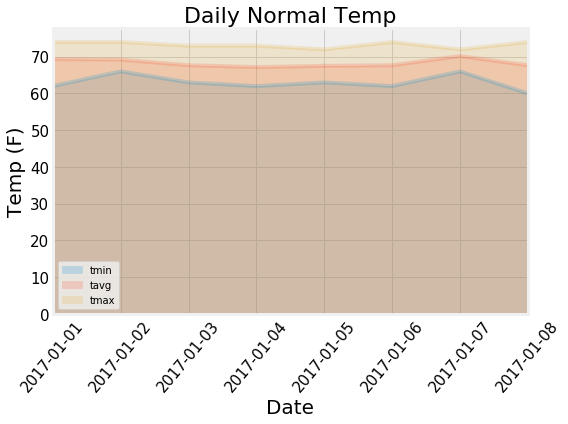

In [130]:
# Plot the daily normals as an area plot with `stacked=False`
# plt.figure(figsize=(14,16))
df_daily_normals.plot.area(alpha = 0.2, stacked=False, figsize=(8,6))
plt.xticks(fontsize=15, rotation=50)
plt.yticks(fontsize=15, rotation=0)
plt.ylabel('Temp (F)', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Daily Normal Temp', fontsize=22)
plt.tight_layout()
plt.savefig("Daily Normal Temp")

<IPython.core.display.Javascript object>


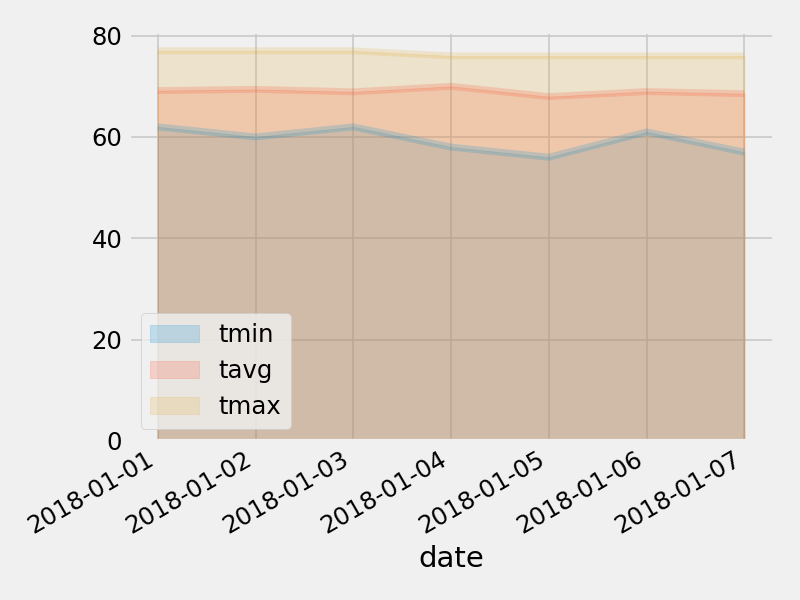

In [23]:
## BELOW IS THE EXAMPLE OUTPUT FROM GUIDE

In [43]:
## EXTRA
## Code testing for setting up the Flask API

# /api/v1.0/precipitation
# Convert the query results to a Dictionary using date as the key and prcp as the value.
# Return the JSON representation of your dictionary.

query_result = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= '2017-07-07').\
order_by(Measurement.date).all()


precipitation_values_list = []
# go through the query_results, grab the date and prcp, put it into dictionary as key and value
# append dictionary to the list 
for i in query_result:
    precipiation_dictionary = {"Date":i.date, "Prcp": i.prcp}
    precipitation_values_list.append(precipiation_dictionary)

precipitation_values_list

[{'Date': '2017-07-07', 'Prcp': 0.0},
 {'Date': '2017-07-07', 'Prcp': 0.02},
 {'Date': '2017-07-07', 'Prcp': None},
 {'Date': '2017-07-07', 'Prcp': None},
 {'Date': '2017-07-07', 'Prcp': 0.0},
 {'Date': '2017-07-07', 'Prcp': 0.18},
 {'Date': '2017-07-07', 'Prcp': 0.3},
 {'Date': '2017-07-08', 'Prcp': 0.0},
 {'Date': '2017-07-08', 'Prcp': 0.02},
 {'Date': '2017-07-08', 'Prcp': 0.06},
 {'Date': '2017-07-08', 'Prcp': 0.0},
 {'Date': '2017-07-08', 'Prcp': 0.0},
 {'Date': '2017-07-08', 'Prcp': 0.02},
 {'Date': '2017-07-09', 'Prcp': 0.0},
 {'Date': '2017-07-09', 'Prcp': 0.09},
 {'Date': '2017-07-09', 'Prcp': 0.0},
 {'Date': '2017-07-09', 'Prcp': 0.0},
 {'Date': '2017-07-09', 'Prcp': 0.11},
 {'Date': '2017-07-09', 'Prcp': 0.0},
 {'Date': '2017-07-10', 'Prcp': 0.0},
 {'Date': '2017-07-10', 'Prcp': 0.0},
 {'Date': '2017-07-10', 'Prcp': 0.0},
 {'Date': '2017-07-10', 'Prcp': None},
 {'Date': '2017-07-10', 'Prcp': 0.0},
 {'Date': '2017-07-10', 'Prcp': 0.02},
 {'Date': '2017-07-10', 'Prcp': 0.02},


In [44]:
# /api/v1.0/stations
# Return a JSON list of stations from the dataset.
query_result = session.query(Station.station).all()
query_result

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [45]:
# /api/v1.0/tobs
# query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.
query_result = session.query(Measurement.tobs).all()
query_result

[(65.0),
 (63.0),
 (74.0),
 (76.0),
 (73.0),
 (70.0),
 (64.0),
 (68.0),
 (73.0),
 (64.0),
 (61.0),
 (66.0),
 (65.0),
 (68.0),
 (64.0),
 (72.0),
 (66.0),
 (66.0),
 (69.0),
 (67.0),
 (67.0),
 (71.0),
 (67.0),
 (76.0),
 (68.0),
 (72.0),
 (70.0),
 (67.0),
 (66.0),
 (67.0),
 (69.0),
 (67.0),
 (67.0),
 (64.0),
 (69.0),
 (73.0),
 (73.0),
 (69.0),
 (69.0),
 (69.0),
 (71.0),
 (61.0),
 (69.0),
 (63.0),
 (64.0),
 (65.0),
 (67.0),
 (68.0),
 (65.0),
 (76.0),
 (75.0),
 (66.0),
 (70.0),
 (72.0),
 (73.0),
 (70.0),
 (71.0),
 (72.0),
 (72.0),
 (69.0),
 (70.0),
 (73.0),
 (72.0),
 (73.0),
 (70.0),
 (71.0),
 (68.0),
 (70.0),
 (72.0),
 (69.0),
 (68.0),
 (74.0),
 (72.0),
 (72.0),
 (73.0),
 (74.0),
 (73.0),
 (73.0),
 (74.0),
 (74.0),
 (74.0),
 (71.0),
 (72.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (73.0),
 (73.0),
 (71.0),
 (71.0),
 (68.0),
 (70.0),
 (71.0),
 (74.0),
 (71.0),
 (75.0),
 (76.0),
 (75.0),
 (75.0),
 (76.0),
 (76.0),
 (76.0),
 (77.0),
 (77.0),
 (73.0),
 (74.0),
 (76.0),
 (76.0),
 (80.0),
 (74.0),
 

In [61]:
# /api/v1.0/<start> and /api/v1.0/<start>/<end>
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
start = '2017-07-01'
sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
query_result = session.query(*sel).\
    filter(Measurement.date >= start).all()

query_result

[(69.0, 78.59298245614035, 87.0)]

In [62]:
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.
start = '2017-07-01'
end = '2017-07-07'
sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
query_result = session.query(*sel).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).all()

query_result

[(74.0, 78.175, 87.0)]